# Ejercico Redes Convolucionales con Pytorch

Clasificación de imágenes



In [1]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [2]:
# Definición de constantes 
import os

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 100
IMAGE_SIZE = 512
DATASET_DIR = 'data/DatasetTumoresCerebrales/'
MODELS_DIR = 'models/'


## Dataset

Como se puede observar en el dataset existe un desbalance en las clases tanto en train como en test.

Para solucionar esto aplicaremos oversampling:
- Aumentaremos el peso de las clases donde haya menos imágenes.
- Aplicaremos DataAugmentation.


In [3]:
# Cargamos dataset
from torchvision import datasets
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, RandomRotation, Grayscale
import torch.utils.data as data

#Aumento de datos
transforms = Compose(
    [
        Grayscale(),
        RandomRotation(30),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor()
    ]
)

train_data = datasets.ImageFolder(DATASET_DIR+'training',transform= transforms)
train, validation = data.random_split(train_data, [0.8, 0.2])
testing = datasets.ImageFolder(DATASET_DIR+'test', transform= transforms)

#Dado los datos que tenemos del dataset y el desbalance creamos el siguiente sampler
sampler = data.WeightedRandomSampler([1/1283, 1/637, 1/837], len(train_data), replacement = True)

In [4]:
train_dataloader = data.DataLoader(train, batch_size=BATCH_SIZE, sampler= sampler)
val_dataloader = data.DataLoader(validation, batch_size=BATCH_SIZE, sampler= sampler)
test_dataloader = data.DataLoader(testing, batch_size=BATCH_SIZE, sampler= sampler)

## Elección de Arquitectura

### Red Convolucional

In [5]:
from torch import nn
from torchinfo import summary

#Bloque convolucional normalizado
def bloque_conv_norm(in_features, out_features):
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, 3, 1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = bloque_conv_norm(1, 32)
        self.conv2 = bloque_conv_norm(32, 64)
        self.conv3 = bloque_conv_norm(64, 64)
        self.conv4 = bloque_conv_norm(64, 32)
        self.linear_out = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(28800, 3)
            )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        logits = self.linear_out(x)
        return logits


In [6]:
# creamos el modelo
torch.cuda.empty_cache()
model = ConvNet() #ConvNet1 #ConvNet2
model.to(device)

summary(model,
        input_size=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ConvNet (ConvNet)                        [100, 1, 512, 512]   [100, 3]             --                   True
├─Sequential (conv1)                     [100, 1, 512, 512]   [100, 32, 255, 255]  --                   True
│    └─Conv2d (0)                        [100, 1, 512, 512]   [100, 32, 510, 510]  320                  True
│    └─BatchNorm2d (1)                   [100, 32, 510, 510]  [100, 32, 510, 510]  64                   True
│    └─ReLU (2)                          [100, 32, 510, 510]  [100, 32, 510, 510]  --                   --
│    └─MaxPool2d (3)                     [100, 32, 510, 510]  [100, 32, 255, 255]  --                   --
├─Sequential (conv2)                     [100, 32, 255, 255]  [100, 64, 126, 126]  --                   True
│    └─Conv2d (0)                        [100, 32, 255, 255]  [100, 64, 253, 253]  18,496               True
│    └─BatchNorm2d

In [7]:
from sklearn.metrics import accuracy_score, f1_score


# función de entrenamiento
def train(dataloader, model, loss_fn, optimizer):

    model.train()
    all_pred = []
    all_labels = []    
    
    for batch, (inputs, labels) in enumerate(dataloader):
        
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Compute prediction error
        pred = model(inputs)
        loss = loss_fn(pred, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        _ ,pred_classes = torch.max(pred, 1)
        
        all_pred.extend(pred_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_pred)
    f1 = (f1_score(all_labels, all_pred, average='macro'))
    
    print(f"Training accuraccy: {acc:.4f} | Training F1-Score: {f1:.4f}")
    
    return acc, f1

#Validate and Test Func
def validate(dataloader, model, loss_fn):
    
    model.eval()
    
    all_pred = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            pred = model(inputs)
            loss = loss_fn(pred, labels)
            _ ,pred_classes = torch.max(pred, 1)

            all_pred.extend(pred_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
                
    acc = accuracy_score(all_labels, all_pred)
    f1 = (f1_score(all_labels, all_pred, average='macro') )
    return acc, f1, total_loss/len(dataloader)


In [8]:
from torch import optim

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Number of epochs
EPOCHS = 5

# Lists to store training and validation results
train_acc = []
train_f1 = []

val_acc = []
val_f1 = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}/{EPOCHS}\n-------------------------------")
    
    # Training phase
    acc, f1 = train(train_dataloader, model, loss_fn, optimizer)
    
    train_acc.append(acc)
    train_f1.append(f1)
    
    # Validation phase
    acc, f1, val_loss = validate(val_dataloader, model, loss_fn)
    print(f"Validation accuraccy: {acc:.3f} | Validation F1-Score: {f1:.3f}")
    val_acc.append(acc)
    val_f1.append(f1)

    scheduler.step(val_loss)
    

print("Training and Validation Done!")

test_acc, test_f1, test_loss = validate(test_dataloader, model, loss_fn)

print(f"Test accuraccy: {test_acc:.3f} | Test F1-Score: {test_f1:.3f} | Test loss: {test_loss:.3f}")

# Save the trained model
torch.save(model.state_dict(), MODELS_DIR + "pre_model_cnn.pth")
print("Model saved as model_cnn.pth")


Epoch 1/5
-------------------------------
Training accuraccy: 0.9750 | Training F1-Score: 0.6530
Validation accuraccy: 1.000 | Validation F1-Score: 1.000
Epoch 2/5
-------------------------------
Training accuraccy: 1.0000 | Training F1-Score: 1.0000
Validation accuraccy: 1.000 | Validation F1-Score: 1.000
Epoch 3/5
-------------------------------
Training accuraccy: 1.0000 | Training F1-Score: 1.0000
Validation accuraccy: 1.000 | Validation F1-Score: 1.000
Epoch 4/5
-------------------------------
Training accuraccy: 1.0000 | Training F1-Score: 1.0000
Validation accuraccy: 1.000 | Validation F1-Score: 1.000
Epoch 5/5
-------------------------------
Training accuraccy: 1.0000 | Training F1-Score: 1.0000
Validation accuraccy: 1.000 | Validation F1-Score: 1.000
Training and Validation Done!
Test accuraccy: 0.454 | Test F1-Score: 0.312 | Test loss: 67.538
Model saved as model_cnn.pth


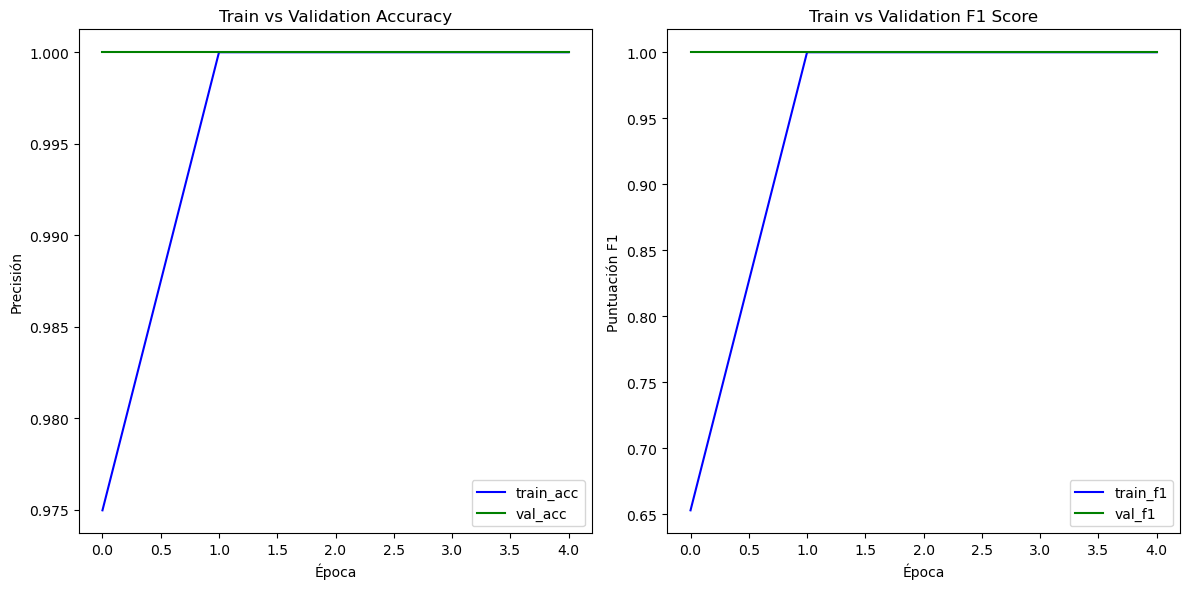

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Graficar train_acc y val_acc en la primera subtrama
ax1.plot(train_acc, label='train_acc', color='blue')
ax1.plot(val_acc, label='val_acc', color='green')
ax1.set_title('Train vs Validation Accuracy')
ax1.set_xlabel('Época')
ax1.set_ylabel('Precisión')
ax1.legend()

# Graficar train_f1 y val_f1 en la segunda subtrama
ax2.plot(train_f1, label='train_f1', color='blue')
ax2.plot(val_f1, label='val_f1', color='green')
ax2.set_title('Train vs Validation F1 Score')
ax2.set_xlabel('Época')
ax2.set_ylabel('Puntuación F1')
ax2.legend()

# Ajustar el espaciado entre las subtramas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Transfer Learning: ResNet18 y EfficientNet_V2_S

## ResNet18

In [10]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, Grayscale
import numpy as np

# Instanciamos el modelo ResNet18 con los pesos por defecto
weights=ResNet18_Weights.DEFAULT
auto_transforms = weights.transforms()

# Cargamos el dataset con las transformaciones originales
transform=Compose([
    Grayscale(num_output_channels=3),
    auto_transforms,
])

train_data = datasets.ImageFolder(DATASET_DIR+'training',transform= transforms)
train, validation = data.random_split(train_data, [0.8, 0.2])

testing = datasets.ImageFolder(DATASET_DIR+'test', transform= transforms)

# Seleccionamos un subconjunto de imágenes de entrenamiento 
reduced_training = Subset(train, range(2500))

train_dataloader = DataLoader(reduced_training, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(testing, batch_size=BATCH_SIZE)

# Estructura de los batches
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Creamos el modelo y congelamos parámetros de la red
model = resnet18(weights=weights).to(device)
for name, para in model.named_parameters():
    para.requires_grad = False

# Cambiamos la capa superior con una capa Lineal con 10 clases de salida
num_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features=num_features,
                    out_features=3,
                    bias=True).to(device)

summary(model,
        input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Shape of X [N, C, H, W]: torch.Size([100, 1, 512, 512])
Shape of y: torch.Size([100]) torch.int64


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [100, 3, 512, 512]   [100, 3]             --                   Partial
├─Conv2d (conv1)                         [100, 3, 512, 512]   [100, 64, 256, 256]  (9,408)              False
├─BatchNorm2d (bn1)                      [100, 64, 256, 256]  [100, 64, 256, 256]  (128)                False
├─ReLU (relu)                            [100, 64, 256, 256]  [100, 64, 256, 256]  --                   --
├─MaxPool2d (maxpool)                    [100, 64, 256, 256]  [100, 64, 128, 128]  --                   --
├─Sequential (layer1)                    [100, 64, 128, 128]  [100, 64, 128, 128]  --                   False
│    └─BasicBlock (0)                    [100, 64, 128, 128]  [100, 64, 128, 128]  --                   False
│    │    └─Conv2d (conv1)               [100, 64, 128, 128]  [100, 64, 128, 128]  (36,864)             False
│    │    

In [13]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [14]:
from torch import optim

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Number of epochs
EPOCHS = 5

# Lists to store training and validation results
train_acc = []
train_f1 = []

val_acc = []
val_f1 = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}/{EPOCHS}\n-------------------------------")
    
    # Training phase
    acc, f1 = train(train_dataloader, model, loss_fn, optimizer)
    
    train_acc.append(acc)
    train_f1.append(f1)
    
    # Validation phase
    acc, f1, val_loss = validate(val_dataloader, model, loss_fn)
    print(f"Validation accuraccy: {acc:.3f} | Validation F1-Score: {f1:.3f}")
    val_acc.append(acc)
    val_f1.append(f1)

    scheduler.step(val_loss)
    

print("Training and Validation Done!")

test_acc, test_f1, test_loss = validate(test_dataloader, model, loss_fn)

print(f"Test accuraccy: {test_acc:.3f} | Test F1-Score: {test_f1:.3f} | Test loss: {test_loss:.3f}")

# Save the trained model
torch.save(model.state_dict(), MODELS_DIR + "pre_model_cnn.pth")
print("Model saved as model_cnn.pth")


Epoch 1/5
-------------------------------


TypeError: 'Subset' object is not callable